# Case study -  Time Series Forecast

Table Of Contents:

* Introduction
* Abstract
* Libraries
* Get Data
* Data Pre Processing
* Exploratory data analysis
* Feature Importance
* Feature selection
* Choose Model & Hyperparameters Tuning
* Make Prediction
* Evaluate Prediction
* Summary

**Introduction**

We Try to Forecast 3 month bicycle rentals on Hourly Interval based on endogen, exogens features.

**Abstract**

Data Contain 40% sparse data(zeros). <br>
Our model show bias prediction which not allow us to deploy model. <br>
My recommendation is to change time frame from hourly to 6 hours.

**Libraries**

In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

**Get Data**

In [3]:
'''from google.colab import drive
drive.mount('/colab/')
from google.colab import files
uploaded = files.upload()
import io

df = pd.read_csv(io.BytesIO(uploaded['data.csv']),index_col='datetime',parse_dates=True)'''

Mounted at /colab/


Saving data.csv to data.csv


In [3]:
import io

df = pd.read_csv(r'C:\\Users\Home\Documents\idan\Exam\NeoGames\data.csv',index_col='datetime',parse_dates=True)

In [4]:
display(df.shape)
df.head()

(10886, 11)

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
datetime,,,,,,,,,,,
2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


 *   When we resampling data in hourly frequency we will get observations contain zeros (sparse data). <br> those zeros will be treated in data cleaning section. <br>
**'Holiday', 'Workingday' are binary attributes.** <br>
Therefore, **we need to replace zeros with -1** and will replace vice versa during data cleaning section.


In [5]:
df['holiday'] = df['holiday'].apply(lambda x: -1 if x==0 else x)
df['workingday'] = df['workingday'].apply(lambda x: -1 if x==0 else x)

In [6]:
# Aggregate data hourly
df = df.resample('h').sum() 
df.shape

(17256, 11)

 * Observations increased from 10,886 to 17,256 meaning we have a lot of hours  without Rentals (Sparse data).
 * **Sparse data can cause to biased results and recommend to change time frame to higher resulation like every 2 hours, day frequencies**
 * For this moment we should create algoritm which predict data hourly according to business definitions.
 * we should treat missing data 

**Data Pre Processing**

* Data Cleaning
* Impute Missing values on attributes (Zeros)
* Transform Data Types


* Data Cleaning

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 17256 entries, 2011-01-01 00:00:00 to 2012-12-19 23:00:00
Freq: H
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   season      17256 non-null  int64  
 1   holiday     17256 non-null  int64  
 2   workingday  17256 non-null  int64  
 3   weather     17256 non-null  int64  
 4   temp        17256 non-null  float64
 5   atemp       17256 non-null  float64
 6   humidity    17256 non-null  int64  
 7   windspeed   17256 non-null  float64
 8   casual      17256 non-null  int64  
 9   registered  17256 non-null  int64  
 10  count       17256 non-null  int64  
dtypes: float64(3), int64(8)
memory usage: 1.6 MB


There isn't missing values

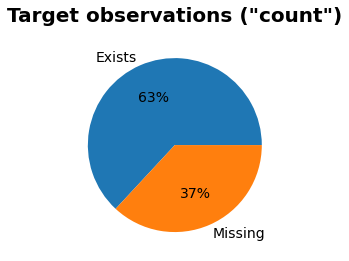

In [8]:
threshold = df['count'].apply(lambda x: 1 if x == 0 else 0).to_frame('missing')
ax=threshold.value_counts().plot(kind='pie',autopct="%.f%%",labels= ['Exists','Missing'] ,textprops={'fontsize': 14})
ax.set_ylabel('');
ax.set_title('Target observations ("count")',size=20,pad=15,fontweight='bold');

**'Count' - target contain 37% missing values.<br>
This issue will burden on our prediction and cause to bias results.**

* Impute Missing values on attributes (Zeros)

In [9]:
df.describe()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
count,17256.000000,17256.000000,17256.000000,17256.000000,17256.000000,17256.000000,17256.000000,17256.000000,17256.00000,17256.000000,17256.000000
mean,1.581305,-0.594808,0.228210,0.894819,12.762699,14.922882,39.041261,8.074537,22.72456,98.130563,120.855123
std,1.499733,0.526377,0.760793,0.849705,11.559260,13.252275,33.549948,8.955684,43.32184,141.513856,171.017327
min,0.000000,-1.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
25%,0.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
50%,1.000000,-1.000000,0.000000,1.000000,13.120000,15.150000,44.000000,7.001500,3.00000,25.000000,29.000000
75%,3.000000,0.000000,1.000000,1.000000,22.960000,26.515000,68.000000,15.001300,27.00000,156.000000,194.000000
max,4.000000,1.000000,1.000000,4.000000,41.000000,45.455000,100.000000,56.996900,367.00000,886.000000,977.000000


Numerical data contain zeros will interpolate by nearest value

In [10]:
# Numerical data
sparse_numericals = ['temp','atemp','humidity','windspeed']
for column in sparse_numericals:
   df[column].replace(0, np.nan, inplace=True)
   df[column].interpolate(method='nearest',inplace=True)

categorical data contain zeros will by forward fill

In [11]:
# Categorical Data
sparse_categoricals = ['season','holiday','workingday','weather']
for column in sparse_categoricals:
   df[column].replace(0, np.nan, inplace=True)
   df[column].fillna(method='ffill',inplace=True)

'Windspeed' contain NaN treat by backward fill

In [12]:
# replace NaN with backward fill
df['windspeed'].fillna(method='bfill',inplace=True)

In [13]:
df.describe()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
count,17256.000000,17256.000000,17256.000000,17256.000000,17256.000000,17256.000000,17256.000000,17256.000000,17256.00000,17256.000000,17256.000000
mean,2.482615,-0.962448,0.381085,1.429937,18.234070,21.529892,63.465577,13.770278,22.72456,98.130563,120.855123
std,1.109815,0.271475,0.924567,0.643686,8.050872,8.831177,18.683246,7.114871,43.32184,141.513856,171.017327
min,1.000000,-1.000000,-1.000000,1.000000,0.820000,0.760000,8.000000,6.003200,0.00000,0.000000,0.000000
25%,1.000000,-1.000000,-1.000000,1.000000,11.480000,13.635000,49.000000,7.001500,0.00000,0.000000,0.000000
50%,2.000000,-1.000000,1.000000,1.000000,18.040000,21.970000,63.000000,12.998000,3.00000,25.000000,29.000000
75%,3.000000,-1.000000,1.000000,2.000000,24.600000,29.545000,79.000000,19.001200,27.00000,156.000000,194.000000
max,4.000000,1.000000,1.000000,4.000000,41.000000,45.455000,100.000000,56.996900,367.00000,886.000000,977.000000


Treat 'holiday' & workingday convert -1 to 0 (for more info: go to get data section)

In [14]:
df['holiday'] = df['holiday'].apply(lambda x: 0 if x==-1 else x)
df['workingday'] = df['workingday'].apply(lambda x: 0 if x==-1 else x)

In [15]:
df[['holiday','workingday']].describe()

,holiday,workingday
count,17256.000000,17256.000000
mean,0.018776,0.690542
std,0.135737,0.462283
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,1.000000
75%,0.000000,1.000000
max,1.000000,1.000000


* Transform Data Types

In [16]:
to_obj = ['season','holiday','workingday','weather']

def to_object(x):
    return x.astype(str)

for column in to_obj :
    df[column] = to_object(df[column])

'season','holiday','workingday','weather' transformed to categorical data

**Exploratory Data Analysis**

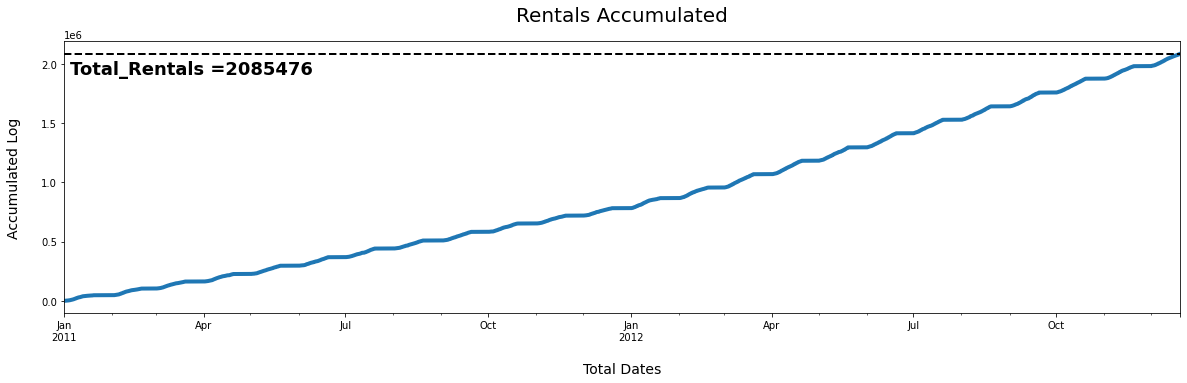

In [17]:
ax=df['count'].cumsum().plot(linewidth=4,figsize=(20, 5));
ax.set_title("Rentals Accumulated",size=20,pad=20);
ax.set_ylabel('Accumulated Log',labelpad=20, size=14);
ax.set_xlabel('Total Dates',labelpad=20, size=14);
total_rentals = df['count'].cumsum().tail(1)[0];
ax.axhline(y=total_rentals, linewidth=2, color='black',linestyle='--');
ax.text(0.005,0.88, f'Total_Rentals ={total_rentals}',size=18,weight="bold", transform=ax.transAxes);


Rentals Increase Exponential - great !

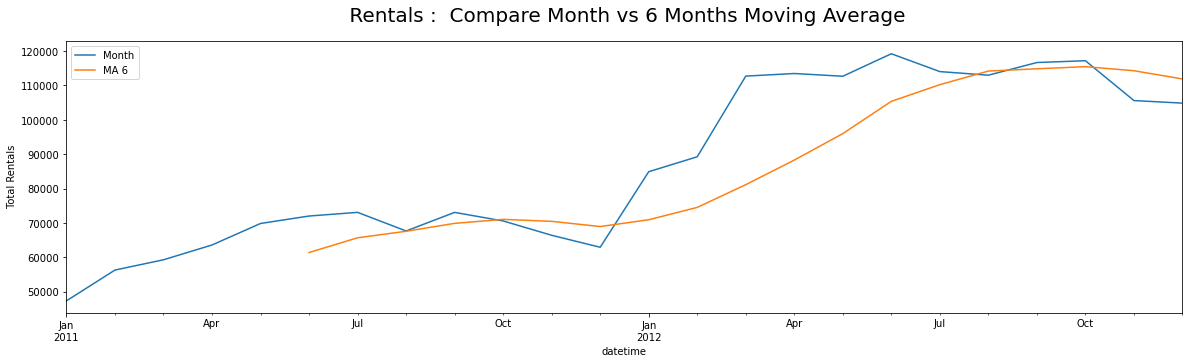

In [18]:
ax=df['count'].resample('M').sum().plot(label='Month', legend=True,figsize=(20,5));
ax= df['count'].resample('M').sum().rolling(window=6).mean().plot(label='MA 6', legend=True,figsize=(20,5));
ax.set_title(' Rentals :  Compare Month vs 6 Months Moving Average',size=20,pad=20);
ax.set_ylabel(' Total Rentals');

  Moving average 6 Month trend line show uptrend. <br>
  In last 2 months we can see rentals below the trend line. <br>
  Same as in the same period previous year. <br>
  We can assume November,  December are weak rental months
  Need more investigation.

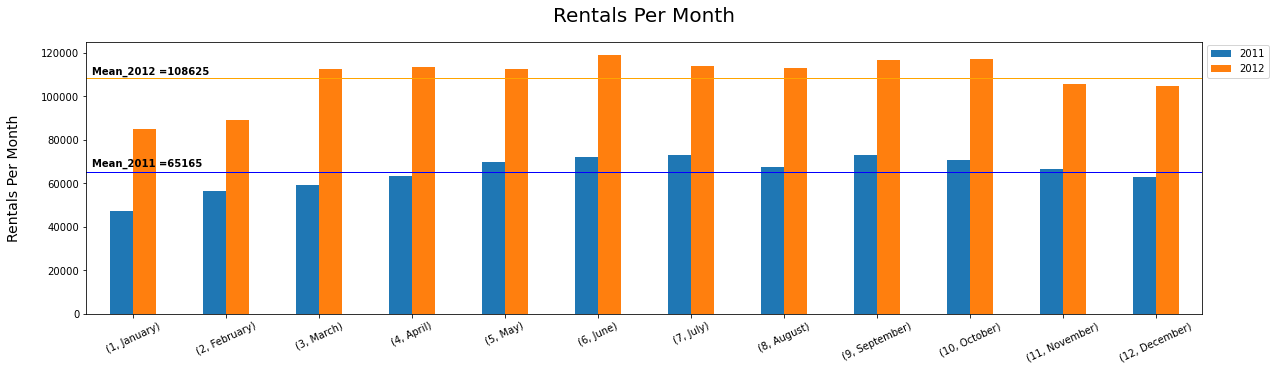

In [19]:
import matplotlib.pyplot as plt
%matplotlib inline
df['month'] = df.index.month
df['month_name']= df.index.month_name()
df['year']= df.index.year

ax=df.sort_values(by='month',ascending=True).groupby(['month','month_name','year'])['count'].sum().unstack().plot.bar(figsize=(20,5),rot=25);
ax.legend(loc=3, bbox_to_anchor=(1.,0.85));
mean_2011 =df.loc[df['year']==2011,:].groupby(['month','month_name','year'])['count'].sum().mean();
ax.axhline(y=mean_2011,linewidth=1, color='b');
mean_2012 = df.loc[df['year']==2012,:].groupby(['month','month_name','year'])['count'].sum().mean();
ax.axhline(y=mean_2012,linewidth=1, color='orange');
ax.text(0.005,0.54, f'Mean_2011 ={round(mean_2011)}',weight="bold", transform=ax.transAxes)
ax.text(0.005,0.88, f'Mean_2012 ={round(mean_2012)}',weight="bold" ,transform=ax.transAxes)
ax.set_ylabel('Rentals Per Month',labelpad=20, size=14)
ax.set_xlabel('')
ax.set_title('Rentals Per Month',size=20,pad=20)
plt.show()

* Rentals per month in 2012 increase 66% in average compare 2011 
* Top 3 Months by order (1-good) :
  1. June
  2. September
  3. October
* Bottom 3 Months By order (12-worst) :
  10. December
  11. February
  12. January

* Rentals by chart seems like seasonality is hidden- should investigate before    choosing model

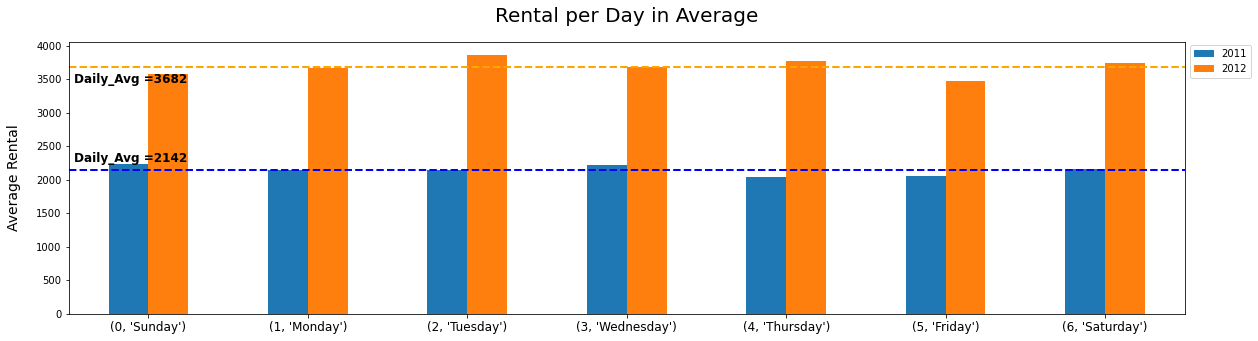

In [20]:
df_dayAggr = df.resample('D').sum()
df_dayAggr['day']= df_dayAggr.index.dayofweek
df_dayAggr['day_name']= df_dayAggr.index.day_name()
df_dayAggr['year']=df_dayAggr.index.year
df_dayAggr['month']=df_dayAggr.index.month
dayAvg_2011 = df_dayAggr.loc[df_dayAggr['year']==2011,'count'].mean()
dayAvg_2012 = df_dayAggr.loc[df_dayAggr['year']==2012,'count'].mean()

ax = df_dayAggr.sort_values(by='day').groupby(['day_name','year'])['count'].mean().unstack().plot.bar(figsize=(20,5),rot=0);
ax.legend(loc=3, bbox_to_anchor=(1.,0.85));
ax.set_ylabel('Average Rental',size=14,labelpad=15)
ax.set_xlabel('')
sort = [(0,'Sunday'),(1,'Monday'),(2,'Tuesday'),(3,'Wednesday'),(4,'Thursday'),(5,'Friday'),(6,'Staturday')]
sort = dict({0:'Sunday',1:'Monday',2:'Tuesday',3:'Wednesday',4:'Thursday',5:'Friday',6:'Saturday'})
ax.set_xticks(range(len(sort)))
ax.set_xticklabels(sort.items(),size=12);
ax.axhline(y=dayAvg_2011, linewidth=2, color='blue',linestyle='--');
ax.text(0.005,0.56, f'Daily_Avg ={round(dayAvg_2011)}',size=12,weight="bold", transform=ax.transAxes);
ax.axhline(y=dayAvg_2012, linewidth=2, color='orange',linestyle='--');
ax.text(0.005,0.85, f'Daily_Avg ={round(dayAvg_2012)}',size=12,weight="bold", transform=ax.transAxes);
ax.set_title('Rental per Day in Average',size=20,pad=20);



* Rentals per day increase by ~72% in average in 2012 compare 2011
* There isn't significant change during weekdays rentals.
* Tuesday, Thursday, Saturday rentals increase. 
* Thursday increase significantly.
* Sunday rentals decrease.
* Friday show in constant low rentals .

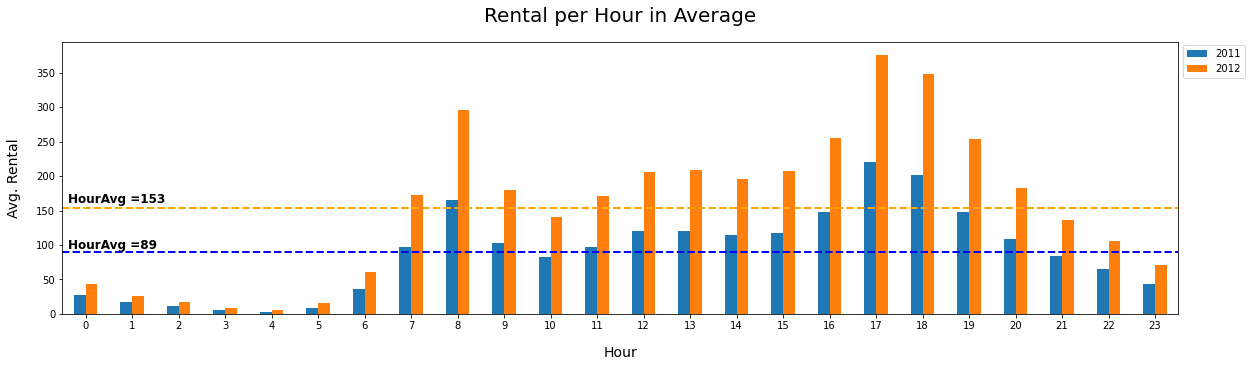

In [21]:
df['Hour']= df.index.hour
HourAvg_2011 = df.loc[df['year']==2011,'count'].mean()
HourAvg_2012 = df.loc[df['year']==2012,'count'].mean()

ax = df.groupby(['Hour','year'])['count'].mean().unstack().plot.bar(figsize=(20,5),rot=0);
ax.legend(loc=3, bbox_to_anchor=(1.,0.85));
ax.set_ylabel('Avg. Rental',size=14,labelpad=15)
ax.set_xlabel('Hour',size=14,labelpad=15)
ax.axhline(y=HourAvg_2011, linewidth=2, color='blue',linestyle='--');
ax.text(0.005,0.24, f'HourAvg ={round(HourAvg_2011)}',size=12,weight="bold", transform=ax.transAxes);
ax.axhline(y=HourAvg_2012, linewidth=2, color='orange',linestyle='--');
ax.text(0.005,0.41, f'HourAvg ={round(HourAvg_2012)}',size=12,weight="bold", transform=ax.transAxes);
ax.set_title('Rental per Hour in Average',size=20,pad=20);

* Most Rentals are between 07:00 - 21:00
* Significant rentals are between 8:00-9:00 , 16:00-20:00. (Bimodal Shape)

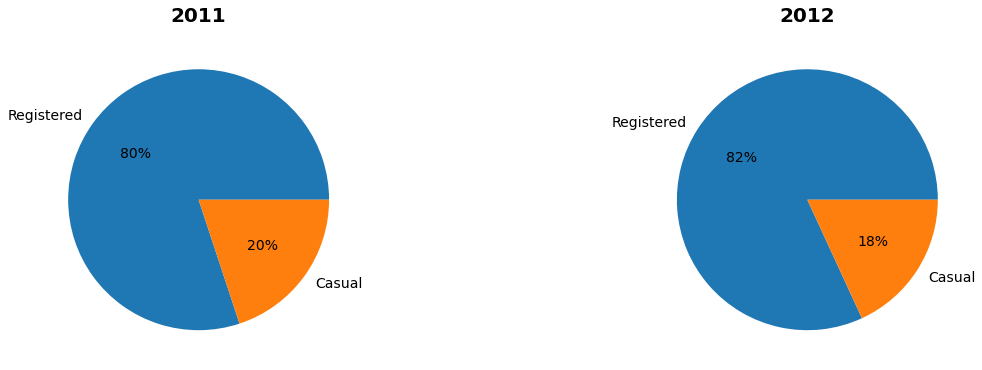

In [22]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(figsize=(20,6),nrows=1, ncols=2)

ax = df.loc[df['year']==2011,:].groupby(['year']).agg({'registered':'sum','casual':'sum'}).unstack().plot(kind='pie',ax=axes[0],autopct="%.f%%",labels= ['Registered','Casual'] ,textprops={'fontsize': 14});
ax.set_ylabel('');
ax.set_title('2011',size=20,pad=15,fontweight='bold');

bx = df.loc[df['year']==2012,:].groupby(['year']).agg({'registered':'sum','casual':'sum'}).unstack().plot(kind='pie',ax=axes[1],autopct="%.f%%",labels= ['Registered','Casual'] ,textprops={'fontsize': 14});
bx.set_ylabel('');
bx.set_title('2012',size=20,pad=15,fontweight='bold');

There is Increase in usage of Registered Numbers 2012 compare 2011 . Great !

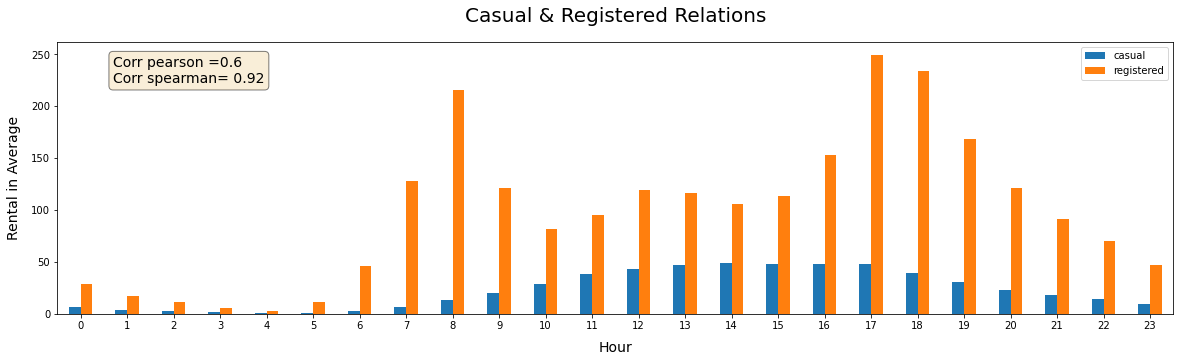

In [23]:
ax = df.groupby('Hour').agg({'casual':'mean','registered':'mean'}).plot(kind='bar',figsize=(20,5),rot=0);
ax.set_ylabel('Rental in Average',size=14,labelpad=10);
ax.set_xlabel('Hour',size=14,labelpad=10);
ax.set_title('Casual & Registered Relations',size=20,pad=20);

pearson_corr = round(df.corr(method='pearson')['casual']['registered'],2)
spearman_corr = round(df.corr(method='spearman')['casual']['registered'],2)
textstr = '\n'.join((f'Corr pearson ={pearson_corr}',f'Corr spearman= {spearman_corr}'))

props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=14,verticalalignment='top', bbox=props);

* We can see different distribution of 'Registered' customers and 'Casual' customers.
* Registered customers use more often in morning : 7:00-10:00 , afternoon : 16:00-19:00 (Bimodal shape)
* Casual customers use more often in noon 13:00-16:00 (Normal distribution like )
* There is correlation between casual and registered customers behavior.
  correlation is non linear.  spearman = 0.92 > pearson = 0.6
* **My estimation : <br>
    Following each distribution  I can assume that predict each group separately and combine them together will show more accuracy results than predict 'count' label.** 

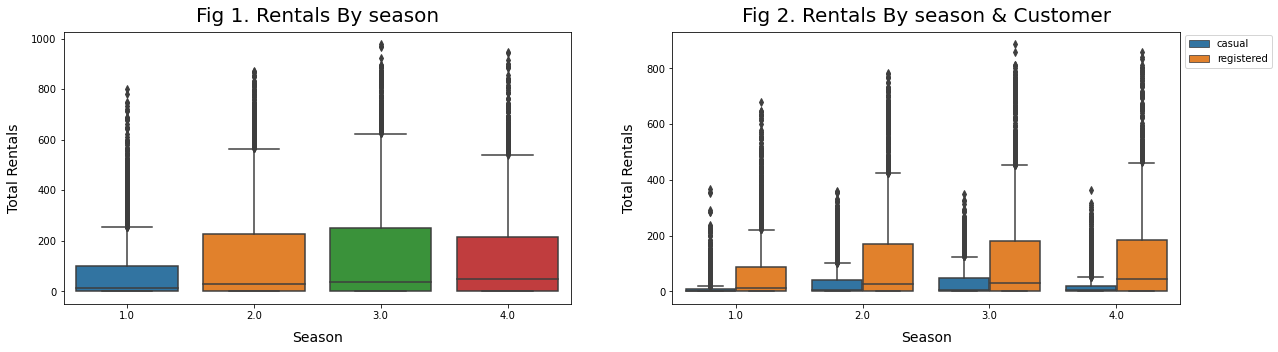

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(figsize=(20,5),nrows=1, ncols=2)
ax= sns.boxplot(x="season", y="count", data=df,ax=axes[0])
ax.set_title('Fig 1. Rentals By season',size=20,pad=10);
ax.set_ylabel('Total Rentals',size=14,labelpad=10);
ax.set_xlabel('Season',size=14,labelpad=10);


chart= pd.melt(df,id_vars='season',value_vars=['casual','registered'],value_name='count',var_name='customer')
bx= sns.boxplot(x="season", y="count", data=chart,hue='customer',ax=axes[1]);
bx.set_title('Fig 2. Rentals By season & Customer',size=20,pad=10);
bx.set_ylabel('Total Rentals',size=14,labelpad=10);
bx.set_xlabel('Season',size=14,labelpad=10);
bx.legend(loc=3, bbox_to_anchor=(1.,0.85));

 
* Fig 1:
  * we can see correlation between season and rentals
* Fig 2:
  * Registered & Casual customers impact by season

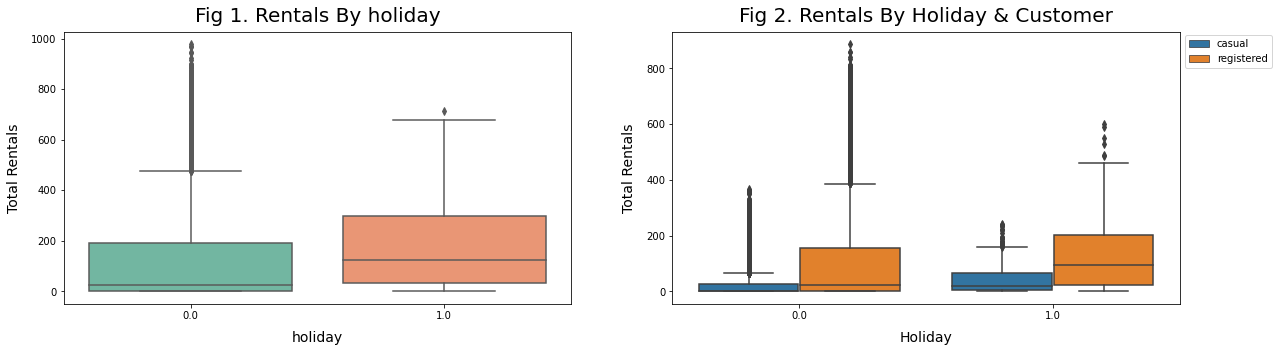

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(figsize=(20,5),nrows=1, ncols=2)
ax= sns.boxplot(x="holiday", y="count", data=df,ax=axes[0],palette ='Set2')
ax.set_title('Fig 1. Rentals By holiday',size=20,pad=10);
ax.set_ylabel('Total Rentals',size=14,labelpad=10);
ax.set_xlabel('holiday',size=14,labelpad=10);


chart= pd.melt(df,id_vars='holiday',value_vars=['casual','registered'],value_name='count',var_name='customer')
bx= sns.boxplot(x="holiday", y="count", data=chart,hue='customer',ax=axes[1] );
bx.set_title('Fig 2. Rentals By Holiday & Customer',size=20,pad=10);
bx.set_ylabel('Total Rentals',size=14,labelpad=10);
bx.set_xlabel('Holiday',size=14,labelpad=10);
bx.legend(loc=3, bbox_to_anchor=(1.,0.85));

* Fig 1:
  * We can see more rentals in holidays. 
* Fig 2:
  * We can see more rentals in holidays for both casual and registered 

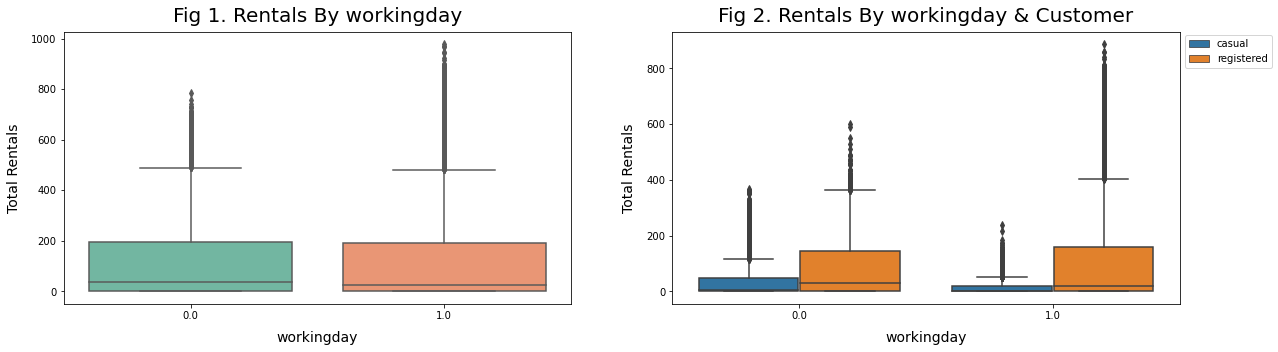

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(figsize=(20,5),nrows=1, ncols=2)
ax= sns.boxplot(x="workingday", y="count", data=df,ax=axes[0],palette ='Set2')
ax.set_title('Fig 1. Rentals By workingday',size=20,pad=10);
ax.set_ylabel('Total Rentals',size=14,labelpad=10);
ax.set_xlabel('workingday',size=14,labelpad=10);


chart= pd.melt(df,id_vars='workingday',value_vars=['casual','registered'],value_name='count',var_name='customer')
bx= sns.boxplot(x="workingday", y="count", data=chart,hue='customer',ax=axes[1] );
bx.set_title('Fig 2. Rentals By workingday & Customer',size=20,pad=10);
bx.set_ylabel('Total Rentals',size=14,labelpad=10);
bx.set_xlabel('workingday',size=14,labelpad=10);
bx.legend(loc=3, bbox_to_anchor=(1.,0.85));

* Fig 1:
  * Rentals are less impacted by workingday. 
* Fig 2:
  * Registered customers activity is not impacted from workingday
  * Casual customers activity are more impacted from workingday: no working >>> more rentals

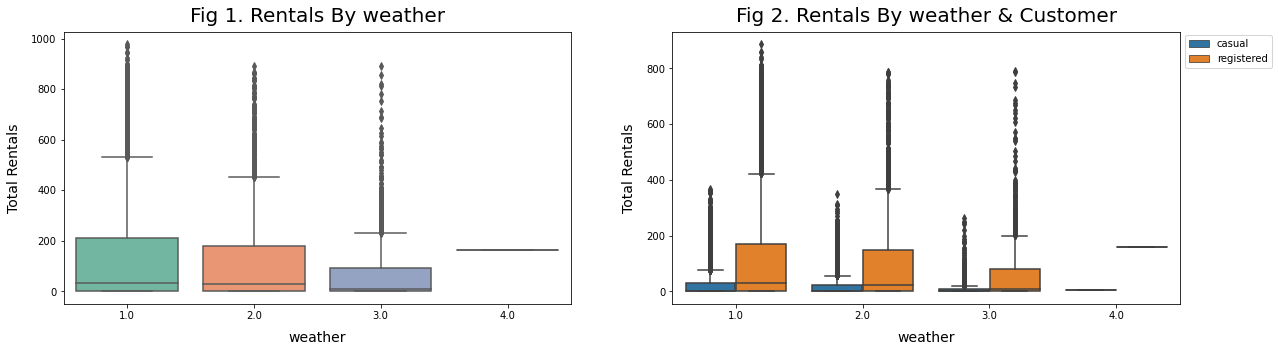

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(figsize=(20,5),nrows=1, ncols=2)
ax= sns.boxplot(x="weather", y="count", data=df,ax=axes[0],palette ='Set2')
ax.set_title('Fig 1. Rentals By weather',size=20,pad=10);
ax.set_ylabel('Total Rentals',size=14,labelpad=10);
ax.set_xlabel('weather',size=14,labelpad=10);


chart= pd.melt(df,id_vars='weather',value_vars=['casual','registered'],value_name='count',var_name='customer')
bx= sns.boxplot(x="weather", y="count", data=chart,hue='customer',ax=axes[1] );
bx.set_title('Fig 2. Rentals By weather & Customer',size=20,pad=10);
bx.set_ylabel('Total Rentals',size=14,labelpad=10);
bx.set_xlabel('weather',size=14,labelpad=10);
bx.legend(loc=3, bbox_to_anchor=(1.,0.85));

* Fig 1:
  * Rentals are impact from weather. 
  * in weather type 4 - only few rentals
* Fig 2:
  * Registered customers activity are impacted from weather
  *  Casual customers activity are impacted from weather

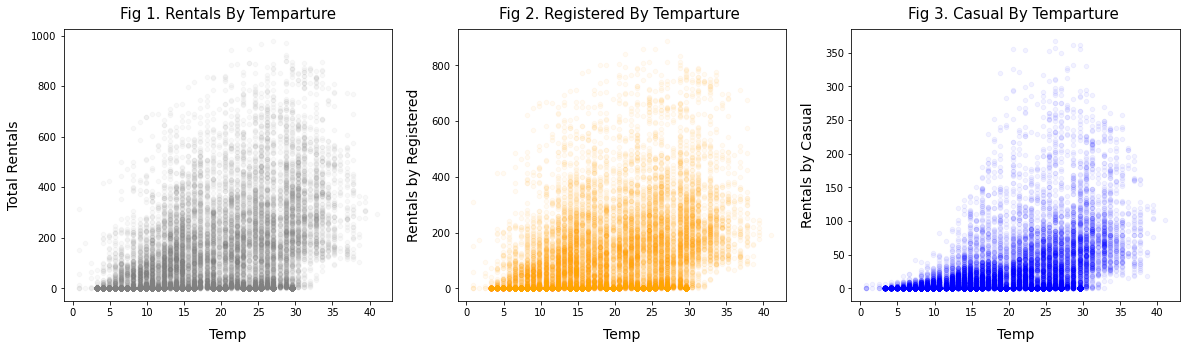

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(figsize=(20,5),nrows=1, ncols=3);

ax= df.plot(kind='scatter',x='temp',y='count',ax=axes[0],alpha=0.05,color='grey');
ax.set_title('Fig 1. Rentals By Temparture',size=15,pad=10);
ax.set_ylabel('Total Rentals',size=14,labelpad=10);
ax.set_xlabel('Temp',size=14,labelpad=10);


bx= df.plot(kind='scatter',x='temp',y='registered',ax=axes[1],alpha=0.05,color='orange');
bx.set_title('Fig 2. Registered By Temparture ',size=15,pad=10);
bx.set_ylabel('Rentals by Registered',size=14,labelpad=10);
bx.set_xlabel('Temp',size=14,labelpad=10);


cx= df.plot(kind='scatter',x='temp',y='casual',ax=axes[2],alpha=0.05,color='blue');
cx.set_title('Fig 3. Casual By Temparture ',size=15,pad=10);
cx.set_ylabel('Rentals by Casual',size=14,labelpad=10);
cx.set_xlabel('Temp',size=14,labelpad=10);
plt.show()

* We can't Identify linear correlation between Temp and Rentals

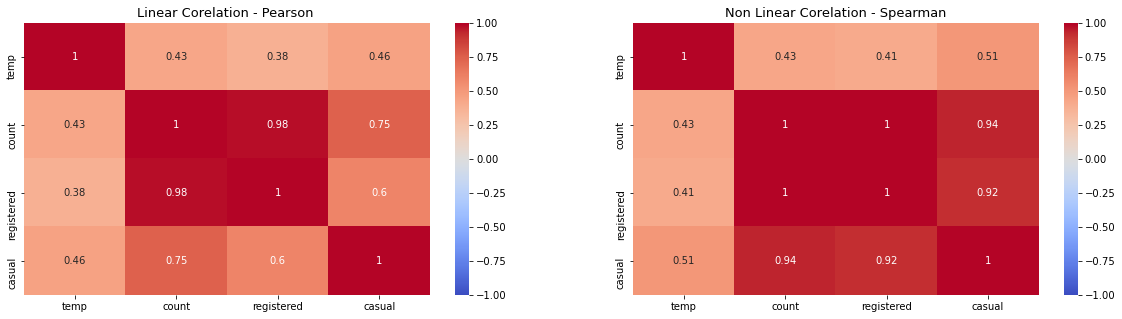

In [29]:
fig, axes = plt.subplots(figsize=(20,5),nrows=1, ncols=2)

# chart 1 pearson
corr = df.loc[:,['temp','count','registered','casual']].corr(method='pearson')
ax = sns.heatmap(corr, annot = True,cmap ='coolwarm',vmin=-1,vmax=1,ax=axes[0]);
ax.set_title('Linear Corelation - Pearson ', y = 1.12, size=13, loc="center");

# chart 1 spearman
corr = df.loc[:,['temp','count','registered','casual']].corr(method='spearman')
ax = sns.heatmap(corr, annot = True,cmap ='coolwarm',vmin=-1,vmax=1,ax=axes[1]);
ax.set_title('Non Linear Corelation - Spearman', y = 1.12, size=13, loc="center");

* There is Medium correlation between Temp and rentals 

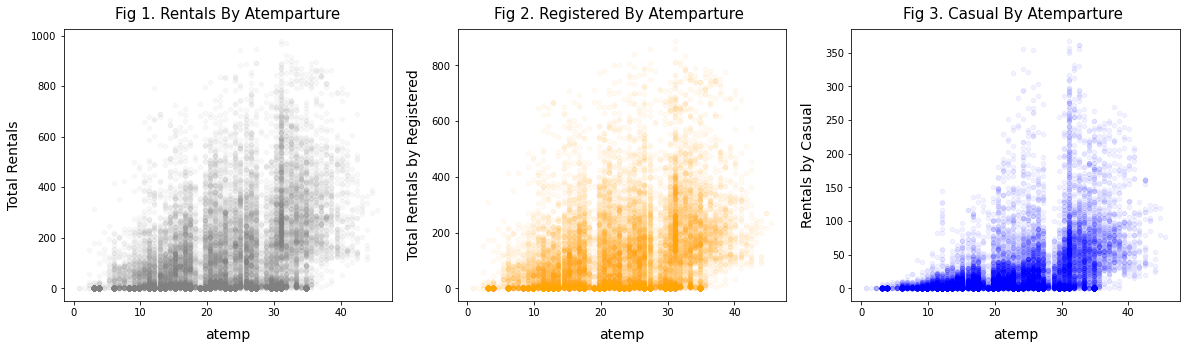

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(figsize=(20,5),nrows=1, ncols=3)

ax= df.plot(kind='scatter',x='atemp',y='count',ax=axes[0],alpha=0.05,color='grey');
ax.set_title('Fig 1. Rentals By Atemparture',size=15,pad=10);
ax.set_ylabel('Total Rentals',size=14,labelpad=10);
ax.set_xlabel('atemp',size=14,labelpad=10);


bx= df.plot(kind='scatter',x='atemp',y='registered',ax=axes[1],alpha=0.05,color='orange');
bx.set_title('Fig 2. Registered By Atemparture ',size=15,pad=10);
bx.set_ylabel('Total Rentals by Registered',size=14,labelpad=10);
bx.set_xlabel('atemp',size=14,labelpad=10);


cx= df.plot(kind='scatter',x='atemp',y='casual',ax=axes[2],alpha=0.05,color='blue');
cx.set_title('Fig 3. Casual By Atemparture ',size=15,pad=10);
cx.set_ylabel('Rentals by Casual',size=14,labelpad=10);
cx.set_xlabel('atemp',size=14,labelpad=10);


* We can't Identify linear correlation between Atemp and Rentals

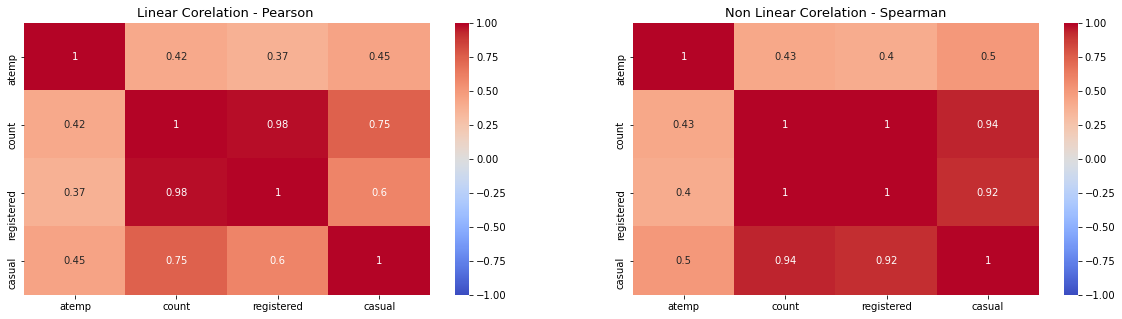

In [31]:
fig, axes = plt.subplots(figsize=(20,5),nrows=1, ncols=2)

# chart 1 pearson
corr = df.loc[:,['atemp','count','registered','casual']].corr(method='pearson')
ax = sns.heatmap(corr, annot = True,cmap ='coolwarm',vmin=-1,vmax=1,ax=axes[0]);
ax.set_title('Linear Corelation - Pearson ', y = 1.12, size=13, loc="center");

# chart 1 spearman
corr = df.loc[:,['atemp','count','registered','casual']].corr(method='spearman')
ax = sns.heatmap(corr, annot = True,cmap ='coolwarm',vmin=-1,vmax=1,ax=axes[1]);
ax.set_title('Non Linear Corelation - Spearman', y = 1.12, size=13, loc="center");

* There is Very Medium correlation between Atemp to Rentals.

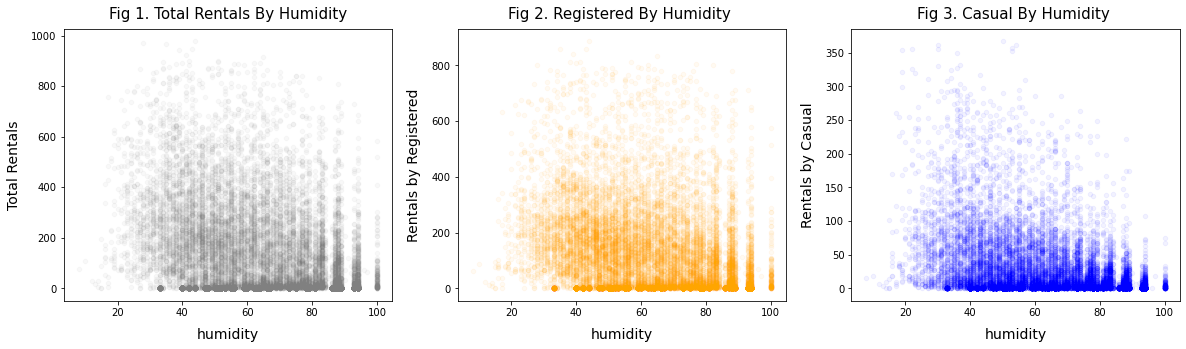

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(figsize=(20,5),nrows=1, ncols=3)

ax= df.plot(kind='scatter',x='humidity',y='count',ax=axes[0],alpha=0.05,color='grey');
ax.set_title('Fig 1. Total Rentals By Humidity',size=15,pad=10);
ax.set_ylabel('Total Rentals',size=14,labelpad=10);
ax.set_xlabel('humidity',size=14,labelpad=10);


bx= df.plot(kind='scatter',x='humidity',y='registered',ax=axes[1],alpha=0.05,color='orange');
bx.set_title('Fig 2. Registered By Humidity ',size=15,pad=10);
bx.set_ylabel('Rentals by Registered',size=14,labelpad=10);
bx.set_xlabel('humidity',size=14,labelpad=10);


cx= df.plot(kind='scatter',x='humidity',y='casual',ax=axes[2],alpha=0.05,color='blue');
cx.set_title('Fig 3. Casual By Humidity ',size=15,pad=10);
cx.set_ylabel('Rentals by Casual',size=14,labelpad=10);
cx.set_xlabel('humidity',size=14,labelpad=10);


* We can't Identify linear correlation between Humidity and Rentals

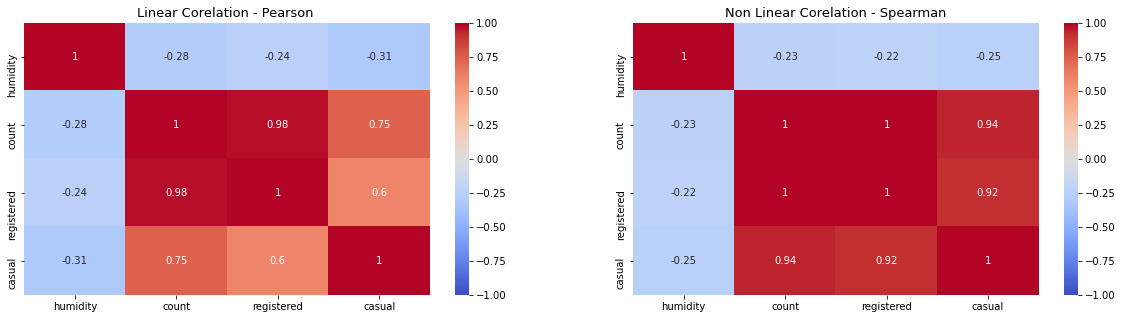

In [33]:
fig, axes = plt.subplots(figsize=(20,5),nrows=1, ncols=2)

# chart 1 pearson
corr = df.loc[:,['humidity','count','registered','casual']].corr(method='pearson')
ax = sns.heatmap(corr, annot = True,cmap ='coolwarm',vmin=-1,vmax=1,ax=axes[0]);
ax.set_title('Linear Corelation - Pearson ', y = 1.12, size=13, loc="center");

# chart 1 spearman
corr = df.loc[:,['humidity','count','registered','casual']].corr(method='spearman')
ax = sns.heatmap(corr, annot = True,cmap ='coolwarm',vmin=-1,vmax=1,ax=axes[1]);
ax.set_title('Non Linear Corelation - Spearman', y = 1.12, size=13, loc="center");


* There is Weak negative correlation between humidity and rentals. <br>
Humidity  go down rentals go up

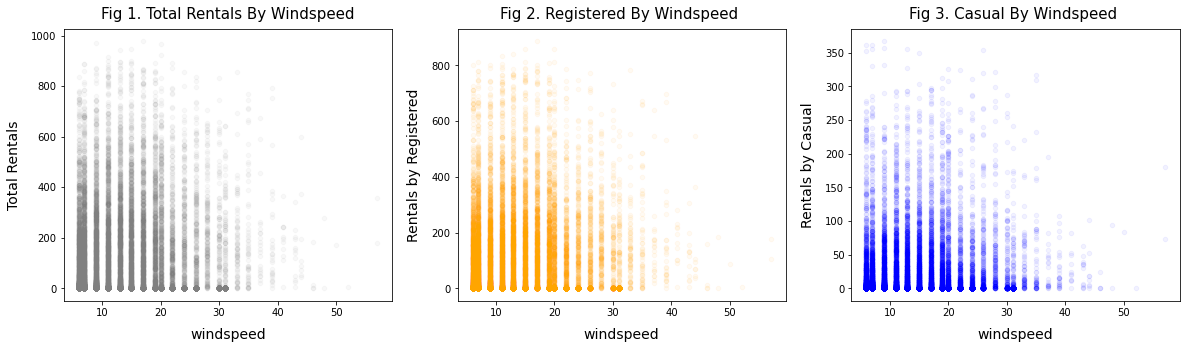

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(figsize=(20,5),nrows=1, ncols=3)

ax= df.plot(kind='scatter',x='windspeed',y='count',ax=axes[0],alpha=0.05,color='grey');
ax.set_title('Fig 1. Total Rentals By Windspeed',size=15,pad=10);
ax.set_ylabel('Total Rentals',size=14,labelpad=10);
ax.set_xlabel('windspeed',size=14,labelpad=10);


bx= df.plot(kind='scatter',x='windspeed',y='registered',ax=axes[1],alpha=0.05,color='orange');
bx.set_title('Fig 2. Registered By Windspeed ',size=15,pad=10);
bx.set_ylabel('Rentals by Registered',size=14,labelpad=10);
bx.set_xlabel('windspeed',size=14,labelpad=10);


cx= df.plot(kind='scatter',x='windspeed',y='casual',ax=axes[2],alpha=0.05,color='blue');
cx.set_title('Fig 3. Casual By Windspeed ',size=15,pad=10);
cx.set_ylabel('Rentals by Casual',size=14,labelpad=10);
cx.set_xlabel('windspeed',size=14,labelpad=10);


We can't see any linear correlation between windspeed and Rentals

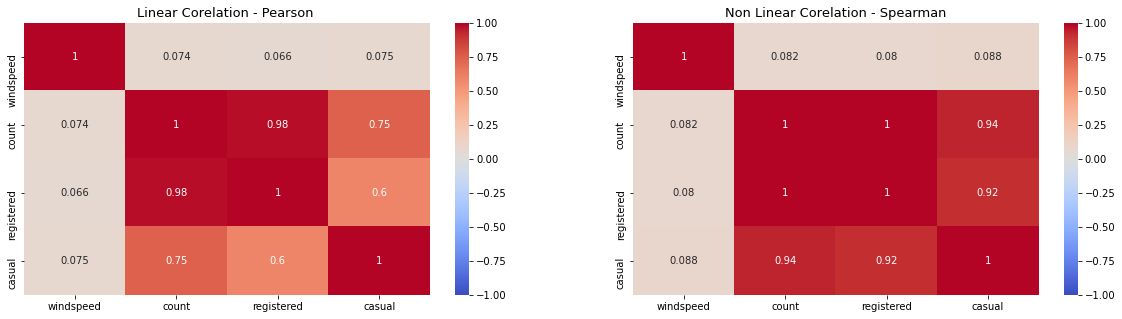

In [35]:
fig, axes = plt.subplots(figsize=(20,5),nrows=1, ncols=2)

# chart 1 pearson
corr = df.loc[:,['windspeed','count','registered','casual']].corr(method='pearson')
ax = sns.heatmap(corr, annot = True,cmap ='coolwarm',vmin=-1,vmax=1,ax=axes[0]);
ax.set_title('Linear Corelation - Pearson ', y = 1.12, size=13, loc="center");

# chart 1 spearman
corr = df.loc[:,['windspeed','count','registered','casual']].corr(method='spearman')
ax = sns.heatmap(corr, annot = True,cmap ='coolwarm',vmin=-1,vmax=1,ax=axes[1]);
ax.set_title('Non Linear Corelation - Spearman', y = 1.12, size=13, loc="center");


* There isn't correlation between windspeed and rentals - weird !

**Correlation Summary:**

  * There is correlation between :
     * Rentals - season
     * Rentals - holidays 
     * Rental - workingday (weak correlation)
     * Rental - weather type
     * Rental - Temp 
     * Rental - Atemp 
     * Rental - Humidity (negative correlation)
     * Rental - windspeed (no correlation) - weird !


## **MultiColinear Test**

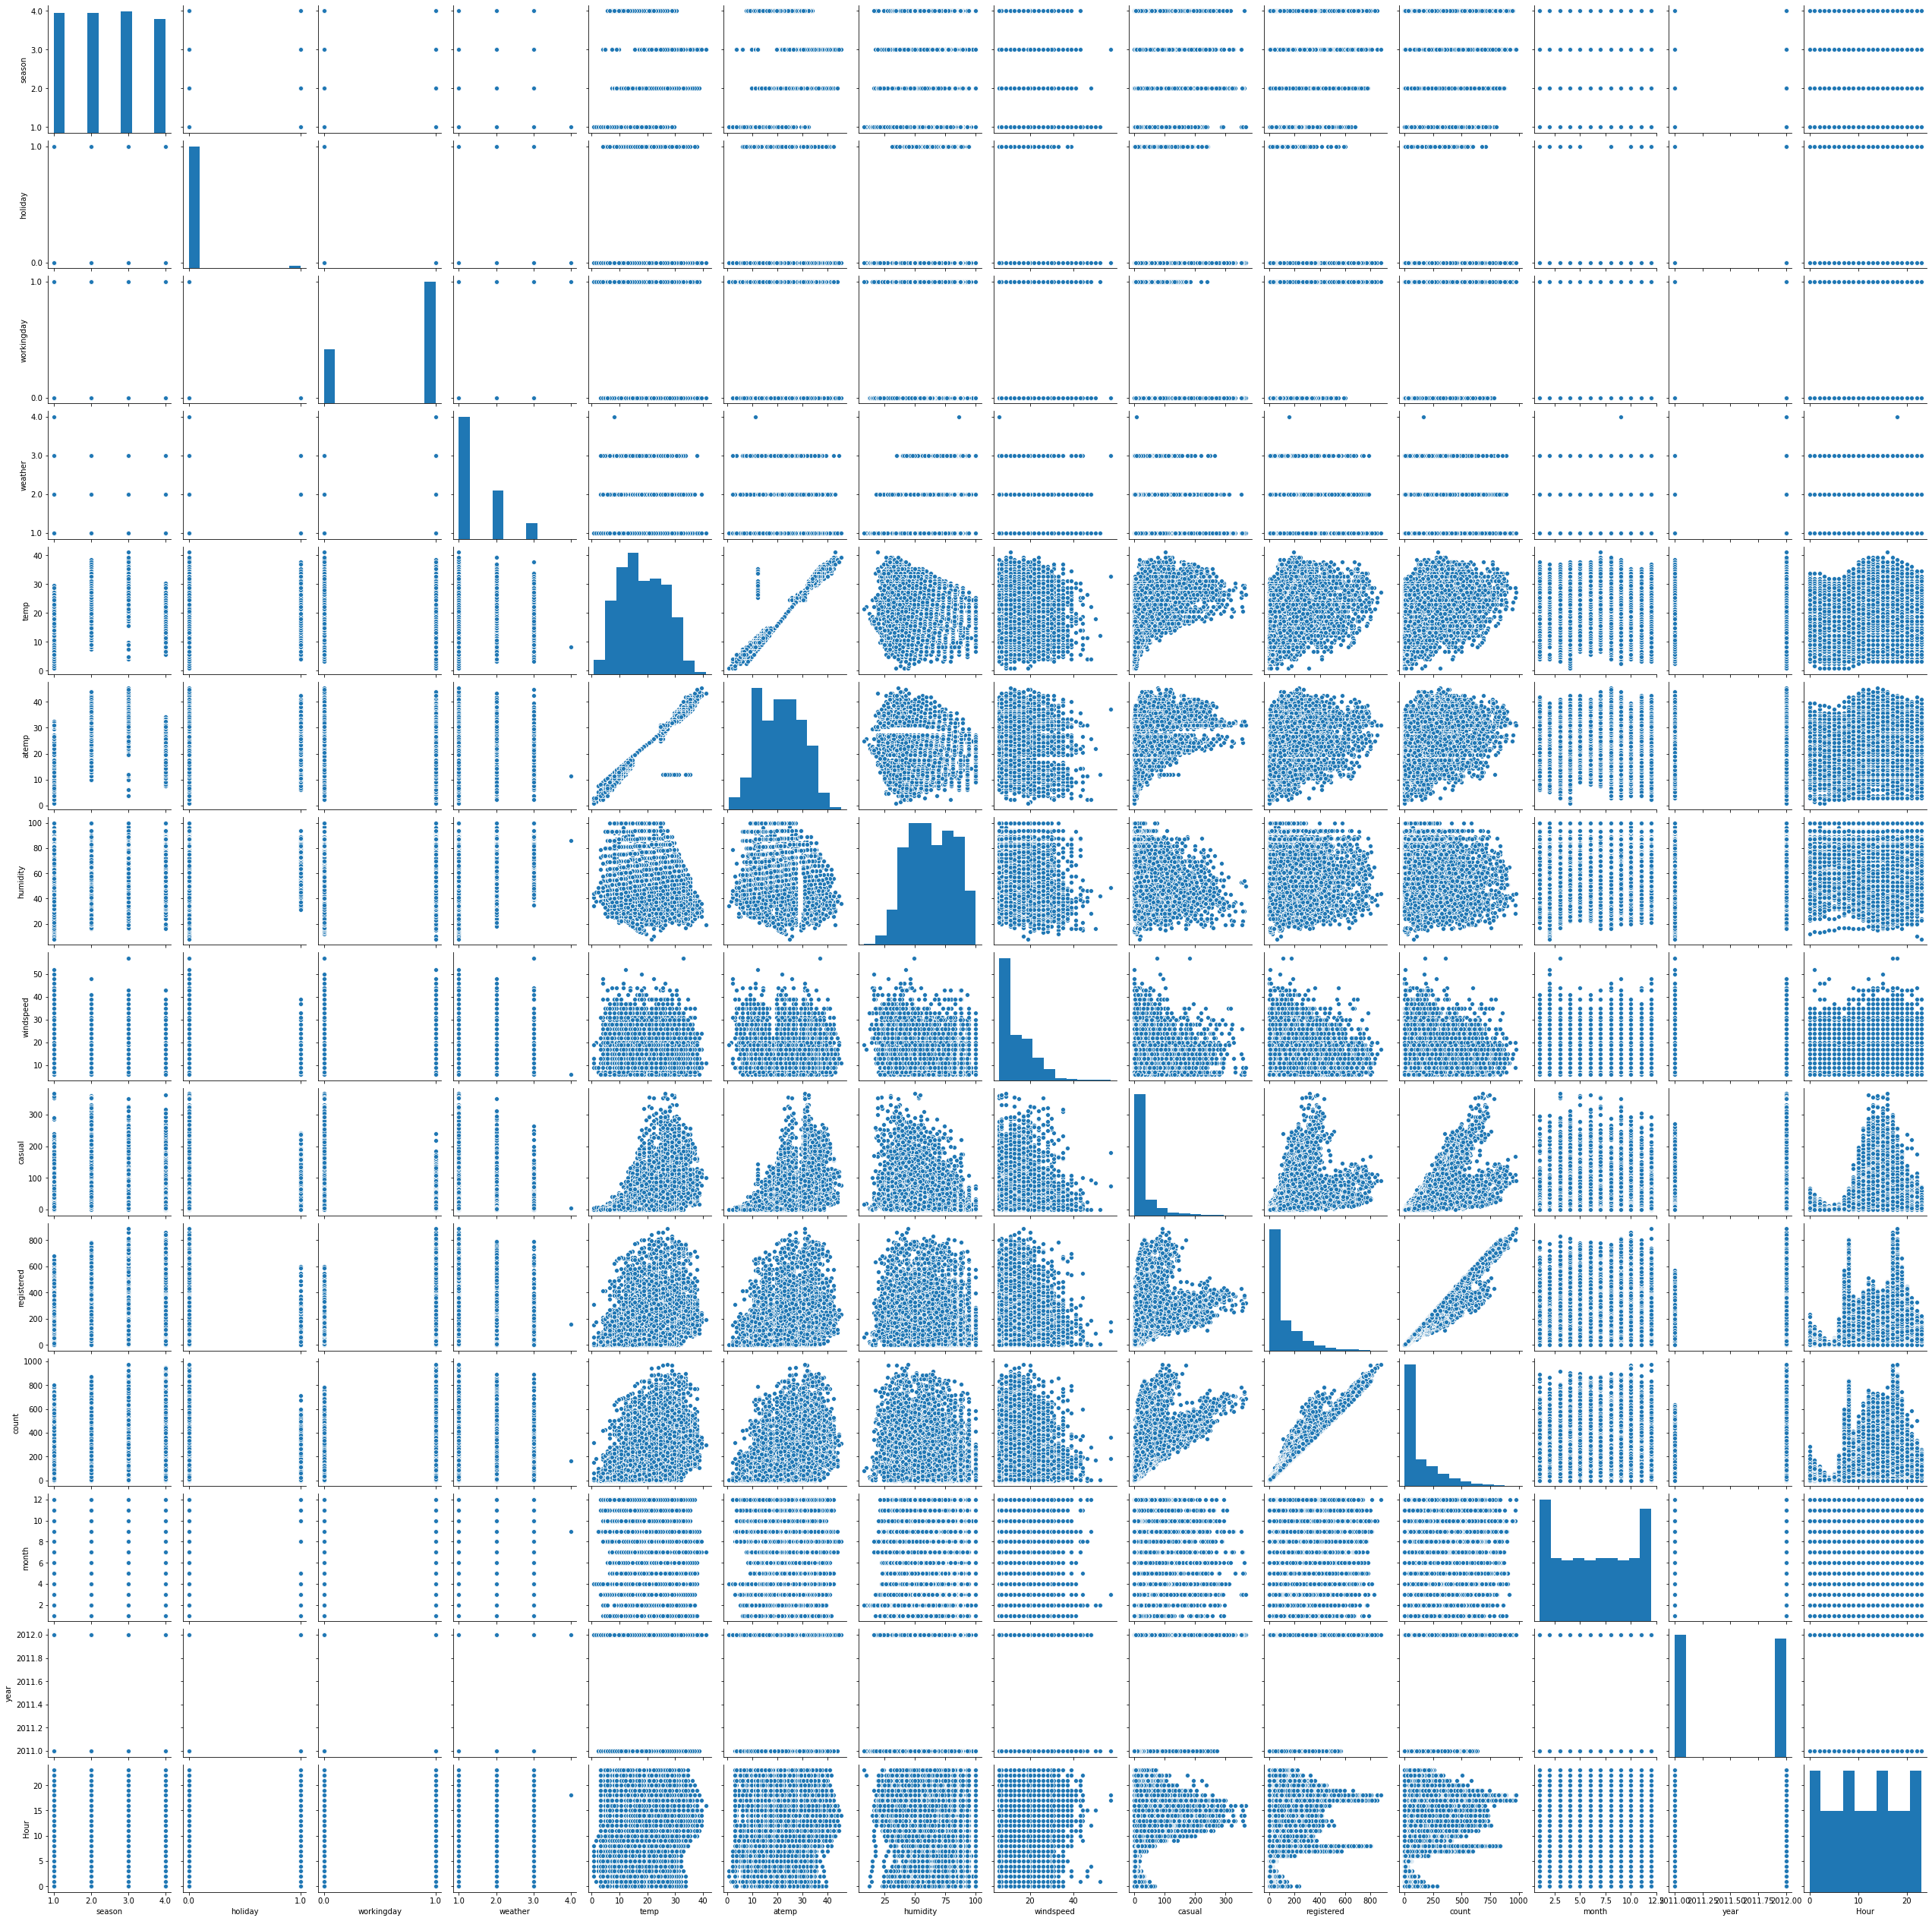

In [36]:
sns.pairplot(df);

**Multi colinear Summary:**

  * There is very strong correlation between Temp - Atemp
  * Atemp should drop. Temp show stronger relation to Rentals

**Drop 'Atemp'**

In [37]:
del df['atemp']

**Drop unrelevant data**

In [38]:
df.drop(columns= ['month','month_name','year','Hour','casual','registered'],inplace=True)

casual and registered are part from target and not attributes

## **Statistic Summary**

In [39]:
df.describe()

,temp,humidity,windspeed,count
count,17256.000000,17256.000000,17256.000000,17256.000000
mean,18.234070,63.465577,13.770278,120.855123
std,8.050872,18.683246,7.114871,171.017327
min,0.820000,8.000000,6.003200,0.000000
25%,11.480000,49.000000,7.001500,0.000000
50%,18.040000,63.000000,12.998000,29.000000
75%,24.600000,79.000000,19.001200,194.000000
max,41.000000,100.000000,56.996900,977.000000


**No outliers to treat**

## **Categorical Frequency**

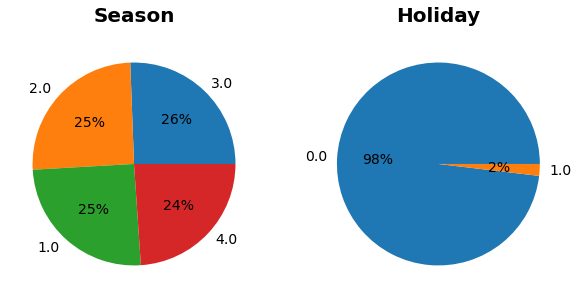

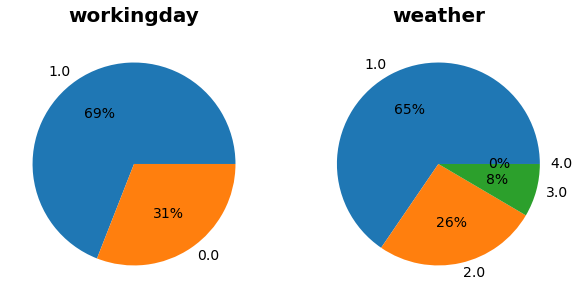

In [40]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(figsize=(10,6),nrows=1, ncols=2)

ax = df['season'].value_counts().plot(kind='pie',ax=axes[0],autopct="%.f%%",textprops={'fontsize': 14});
ax.set_ylabel('');
ax.set_title('Season',size=20,pad=15,fontweight='bold');

bx = df['holiday'].value_counts().plot(kind='pie',ax=axes[1],autopct="%.f%%",textprops={'fontsize': 14});
bx.set_ylabel('');
bx.set_title('Holiday',size=20,pad=15,fontweight='bold');

fig, axes = plt.subplots(figsize=(10,6),nrows=1, ncols=2)
ax = df['workingday'].value_counts().plot(kind='pie',ax=axes[0],autopct="%.f%%",textprops={'fontsize': 14});
ax.set_ylabel('');
ax.set_title('workingday',size=20,pad=15,fontweight='bold');

bx = df['weather'].value_counts().plot(kind='pie',ax=axes[1],autopct="%.f%%",textprops={'fontsize': 14});
bx.set_ylabel('');
bx.set_title('weather',size=20,pad=15,fontweight='bold');


In 'Weather' we can see category 4 is less than 1% . <br>
Can cause problem when Train- Test split. <br>


## **Categorical correlation (Chi Square)**

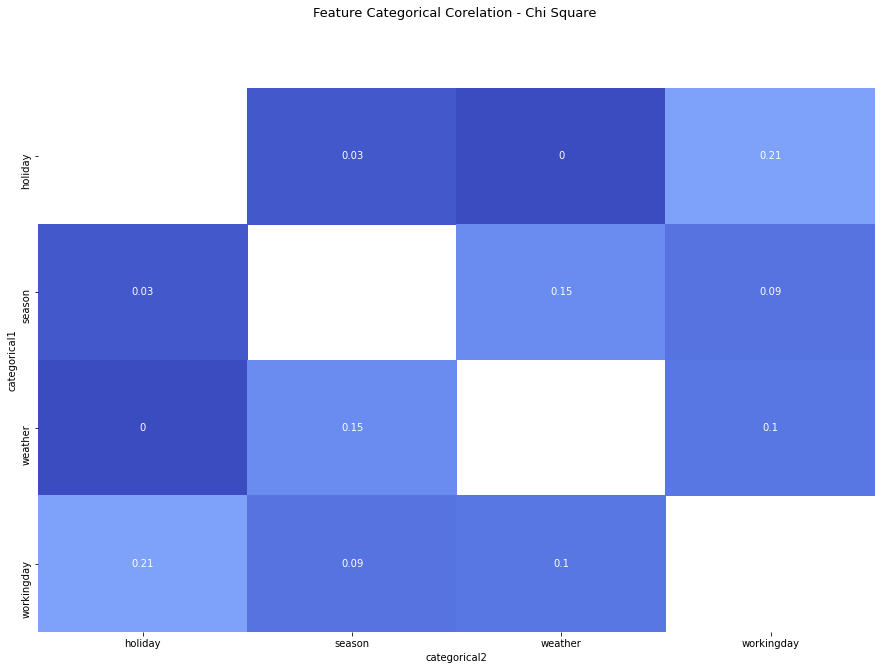

In [41]:
import pandas as pd
import numpy as np
import scipy.stats as ss
import seaborn as sns


categorical_data = df.loc[:,df.columns.isin(df.select_dtypes('object').columns.to_list())]


# calculate correlation
feature1 = []
feature2 = []
cramer = [] 

def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x,y)
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2-((k-1)*(r-1))/(n-1))
    rcorr = r-((r-1)**2)/(n-1)
    kcorr = k-((k-1)**2)/(n-1)
    return np.sqrt(phi2corr/min((kcorr-1),(rcorr-1)))

x=0
while True:
     y=0
     while y < len(categorical_data.columns) :
          feature1.append(categorical_data.iloc[:,x].name)
          feature2.append(categorical_data.iloc[:,y].name) 
          result = cramers_v(categorical_data.iloc[:,x], categorical_data.iloc[:,y])         
          cramer.append(result)    
          y+=1
     x+=1
     if x == len(categorical_data.columns) :
        break
  

# create correlation table
cramer_table = pd.DataFrame(zip(feature1,feature2,cramer)).rename(columns={0:'categorical1',1:'categorical2',2:'Cramer correlation'})


#show heat map (above 0.75 strong relation)
cramer_table = cramer_table.loc[(cramer_table['Cramer correlation'] >=0.0) & (cramer_table.categorical1 != cramer_table.categorical2),:]
plt.figure(figsize=(15,10))
plt.title('Feature Categorical Corelation - Chi Square ', y = 1.12, size=13, loc="center")
sns.heatmap(pd.crosstab(cramer_table.categorical1,
            cramer_table.categorical2,
            values=round(cramer_table['Cramer correlation'],2),
            aggfunc= 'sum'),
            cmap="coolwarm", annot=True, cbar=False,vmin = 0, vmax = 1,center = 0.5)
plt.show()

No correlation between categorical features

## **Feature Importance**

In [42]:
X = df.drop(columns='count')
y = df['count']

In [43]:
def to_integer (feature):
   return feature.astype('float').astype('int')
   
for feature in ['season','holiday','workingday','weather']:
    df[feature] = to_integer(df[feature])

**1.Boruta random forest**

In [44]:
import numpy as np
from boruta import BorutaPy
from sklearn.ensemble import RandomForestRegressor

###initialize Boruta
forest = RandomForestRegressor(n_jobs = -1, max_depth = 5)
boruta = BorutaPy(estimator = forest, n_estimators = 'auto', max_iter = 100) # number of trials to perform


### fit Boruta (it accepts np.array, not pd.DataFrame)
boruta.fit(np.array(X),np.array(y))

# score
green_area = X.columns[boruta.support_].to_list()
blue_area = X.columns[boruta.support_weak_].to_list()
Boruta_RF = pd.Series(green_area + blue_area).to_frame('Boruta_RF')

**2.Light GBM (boosting method)**

Learn from weak Attributes

In [45]:
import lightgbm as lgb
model = lgb.LGBMRegressor(boosting_type='dart',objective='RMSE',random_state=1,reg_alpha=1,learning_rate= 0.0000001,subsample= 0.5)
model.fit(X.values,y)
LGB = pd.DataFrame(zip(X.columns.to_list(),model.feature_importances_.tolist()),columns=['feature','importance'])
LGB = LGB.loc[LGB.importance > 0,'feature'].to_frame('LGB').reset_index(drop=True)

3. **Summary : Voting for importance attributes**

In [46]:
Attributes = pd.Series(X.columns).to_frame('Attributes')
summary = pd.merge(
                    left =pd.merge(Attributes,Boruta_RF,how='left',left_on='Attributes',right_on='Boruta_RF')
                    ,right =  LGB, left_on='Attributes',right_on='LGB',how='left')

for column in summary.drop(columns = 'Attributes').columns:
    summary[column] = summary[column].apply(lambda x: 0 if pd.isnull(x)==True else 1)

summary['score'] = summary.sum(axis=1)
summary = summary.sort_values(by='score',ascending=False).reset_index(drop=True) 
display(summary)

,Attributes,Boruta_RF,LGB,score
0,season,1,1,2
1,workingday,1,1,2
2,weather,1,1,2
3,temp,1,1,2
4,humidity,1,1,2
5,windspeed,1,1,2
6,holiday,0,0,0


## **Feature selection**

* Holiday isn't important and should drop - weird ! <br> (previously we saw there is correlation)
* Other features as important according table summary of feature importance

In [47]:
df = df.drop(columns='holiday')

In [48]:
print("""
           Important features:\n
            ['season', 'workingday', 'weather', 'temp', 'humidity', 'windspeed']
      """)


           Important features:

            ['season', 'workingday', 'weather', 'temp', 'humidity', 'windspeed']
      


## **Train, Test split**

* Train - all data except last 3 month (hourly)
* Test - Last 3 month (hourly)

In [49]:
train = df[:'2012-09-18'].reset_index()
test = df['2012-09-19':'2012-12-19'].reset_index()

## **Encoding Categorical - One Hot Encoding**

In [50]:
to_obj = ['season','workingday','weather']

def to_object(x):
    return x.astype(str)

for column in to_obj :
    train[column] = to_object(train[column])
    test[column] = to_object(test[column])

In [51]:
X_categorical = ['season','workingday','weather']
X_numerical = ['temp','humidity','windspeed']
y_target= 'count'

# Fit transform One Hot Encoding train
DummyTable = {}
features = {}
categorical_features = pd.DataFrame()
for column in X_categorical:
    DummyTable[column] = pd.concat( [train[column].drop_duplicates().to_frame().reset_index(drop=True)
                          ,pd.get_dummies(data=train[column].to_frame(),columns=[column],drop_first=False).drop_duplicates().reset_index(drop=True)]  
                          ,axis= 1)
    features[column] = pd.merge(train[column].to_frame(),DummyTable[column],how='left',on=column)
    categorical_features = pd.concat([categorical_features,features[column]],axis=1)
    categorical_features.drop(columns= [column,column+'_1'],inplace=True)

train = pd.concat([train['datetime'],categorical_features,train.loc[:,train.columns.isin(X_numerical)],train[y_target]],axis=1).set_index('datetime')

# Predict One Hot Encoding test
categorical_features = pd.DataFrame()
for column in X_categorical:
    features[column] = pd.merge(test[column].to_frame(),DummyTable[column],how='left',on=column)
    categorical_features = pd.concat([categorical_features,features[column]],axis=1)
    categorical_features.drop(columns= [column,column+'_1'],inplace=True)

test = pd.concat([test['datetime'],categorical_features,test.loc[:,test.columns.isin(X_numerical)],test[y_target]],axis=1).set_index('datetime')


In [52]:
# add index frequency 
train.index.freq='h'
test.index.freq='h'

## **Choosing Model Type & Hyperparameter Tuning**

**Models - focus on Target only without other features**

Simple Exponential Smoothing

In [53]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing


span = 24 # hours per day
alpha = 2/(span+1)

model =SimpleExpSmoothing(train['count']).fit(smoothing_level=alpha,optimized=False)
SimpleExp = model.forecast(2208).rename('prediction')

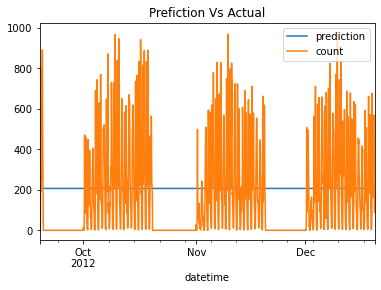

In [54]:
ax= SimpleExp.plot(legend=True);
ax.set_title('Prefiction Vs Actual')
test['count'].plot(legend=True);

SimpleExp didn't learn anything

**Double Exponential smoothing**

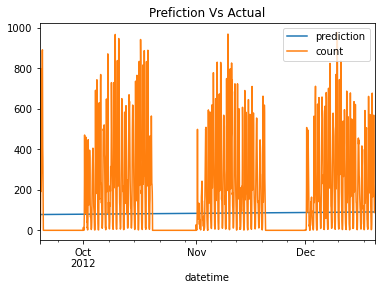

In [55]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

span = 24
alpha = 2/(span+1)
model = ExponentialSmoothing(train['count'], trend='add').fit()
ExponentialSmooth = model.forecast(2208).rename('prediction')

bx= ExponentialSmooth.plot(legend=True);
bx.set_title('Prefiction Vs Actual')
test['count'].plot(legend=True);

ExponentialSmooth didn't learn anything

**Triple Exponential**

C:\Users\Home\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)


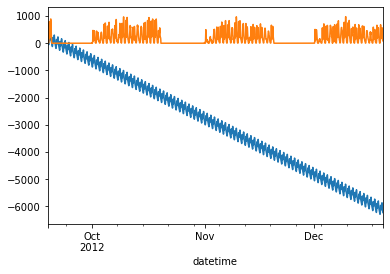

In [56]:
model = ExponentialSmoothing(train['count'], trend='add',seasonal='add',seasonal_periods=24).fit()
tripleExp = model.forecast(2208).rename('prediction')

tripleExp.plot();
test['count'].plot();

Triple exponent didn't learn anything

**AR - autoregressive model**

C:\Users\Home\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


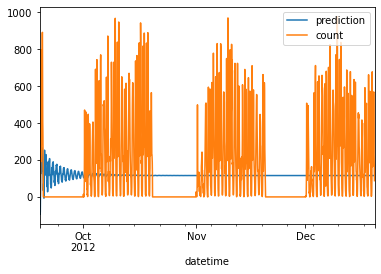

In [58]:
from statsmodels.tsa.ar_model import AR,ARResults

model = AR(train['count'])
ARfit = model.fit(method='mle')
start = len(train)
end = len(train)+len(test)-1
predictions = ARfit.predict(start=start,end=end,dynamic=False).rename('prediction')

predictions.plot(legend=True);
test['count'].plot(legend=True);

Model Didn't learn Anything

**Stationary Test**

stationary meaning - no trend and no seasonality

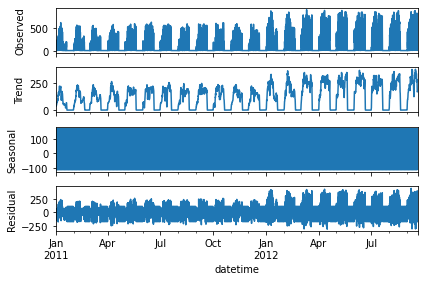

In [59]:
from statsmodels.tsa.seasonal import seasonal_decompose

result = seasonal_decompose(train['count'], model='add')  # model='mul' also works
result.plot();

* We can see **in hourly time frame** :
  * No clear trend 
  * No clear seasonality


In [60]:
from statsmodels.tsa.stattools import adfuller

def adf_test(series,title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out[f'critical value ({key})']=val
        
    print(out.to_string())          # .to_string() removes the line "dtype: float64"
    
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")

adf_test(train['count'])

Augmented Dickey-Fuller Test: 
ADF test statistic     -6.295789e+00
p-value                 3.508719e-08
# lags used             4.300000e+01
# observations          1.500400e+04
critical value (1%)    -3.430786e+00
critical value (5%)    -2.861733e+00
critical value (10%)   -2.566873e+00
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


**ARMA Model**

In [96]:
from statsmodels.tsa.arima_model import ARMA,ARMAResults,ARIMA,ARIMAResults
from pmdarima import auto_arima

auto_arima(y= train['count'],seasonal=False).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                15048
Model:               SARIMAX(5, 1, 3)   Log Likelihood              -84383.055
Date:                Sat, 30 Jan 2021   AIC                         168784.110
Time:                        21:10:11   BIC                         168852.681
Sample:                             0   HQIC                        168806.858
                              - 15048                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2720      0.007     38.082      0.000       0.258       0.286
ar.L2         -0.3337      0.007    -50.597      0.000      -0.347      -0.321
ar.L3          0.7917      0.006    124.788      0.000       0.779       0.804
ar.L4         -0.4549      0.006    -76.239      0.000      -0.467      -0.443
ar.L5          0.1549      0.008     20.043      0.000       0.140       0.170
ma.L1          0.0340      0.004      8.716      0.000       0.026       0.042
ma.L2         -0.0186      0.004     -4.861      0.000      -0.026      -0.011
ma.L3         -0.9485      0.004   -246.909      0.000      -0.956      -0.941
sigma2      4464.5412     30.530    146.233      0.000    4404.703    4524.380
===================================================================================
Ljung-Box (Q):                     7890.03   Jarque-Bera (JB):             38848.18
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               2.53   Skew:                             0.42
Prob(H) (two-sided):                  0.00   Kurtosis:                        10.83
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [97]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

model = SARIMAX(train['count'],order=(5, 1, 3))
results = model.fit()

start=len(train)
end=len(train)+len(test)-1
predictions = results.predict(start=start, end=end, dynamic=False, typ='levels').rename('prediction')

C:\Users\Home\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


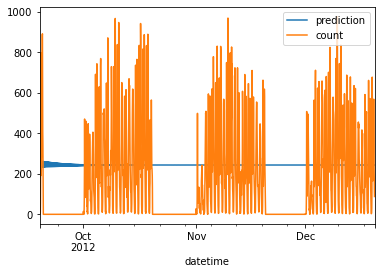

In [98]:
predictions.plot(legend=True);
test['count'].plot(legend=True);

model didn't learn anything

**Models - focus on Target & Exogen Features**

SARIMAX - contain features and target

In [104]:
from pmdarima import auto_arima

X_train = train.drop(columns='count')
y_train = train['count']
auto_arima(y= y_train,X=X_train,seasonal=False,enforce_invertibility=False).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                15048
Model:               SARIMAX(5, 1, 1)   Log Likelihood              -84304.115
Date:                Sat, 30 Jan 2021   AIC                         168642.230
Time:                        21:54:53   BIC                         168771.752
Sample:                    01-01-2011   HQIC                        168685.197
                         - 09-18-2012                                         
Covariance Type:                  opg                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
season_2       -15.3016      8.792     -1.740      0.082     -32.533       1.930
season_3       -39.3403     10.396     -3.784      0.000     -59.716     -18.965
season_4         1.4729      9.698      0.152      0.879     -17.534      20.480
workingday_0    23.3316      4.362      5.349      0.000      14.783      31.880
weather_2        0.0494      1.390      0.036      0.972      -2.676       2.774
weather_3       -5.6365      2.258     -2.497      0.013     -10.061      -1.212
weather_4      -14.0771     52.168     -0.270      0.787    -116.325      88.171
temp             5.4415      0.383     14.225      0.000       4.692       6.191
humidity        -0.9098      0.078    -11.739      0.000      -1.062      -0.758
windspeed        0.2263      0.099      2.286      0.022       0.032       0.420
ar.L1            1.2011      0.006    186.359      0.000       1.188       1.214
ar.L2           -0.6036      0.011    -55.158      0.000      -0.625      -0.582
ar.L3            0.1635      0.015     10.955      0.000       0.134       0.193
ar.L4            0.0816      0.015      5.457      0.000       0.052       0.111
ar.L5           -0.1383      0.009    -14.579      0.000      -0.157      -0.120
ma.L1           -0.9679      0.003   -313.426      0.000      -0.974      -0.962
sigma2        4300.7720     23.775    180.897      0.000    4254.174    4347.370
===================================================================================
Ljung-Box (Q):                     6716.83   Jarque-Bera (JB):             64205.81
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               2.51   Skew:                             0.54
Prob(H) (two-sided):                  0.00   Kurtosis:                        13.06
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [105]:
model = SARIMAX(train['count'],order=(5,1,1))
results = model.fit()

start=len(train)
end=len(train)+len(test)-1
predictions = results.predict(start=start, end=end, dynamic=False, typ='levels').rename('prediction')

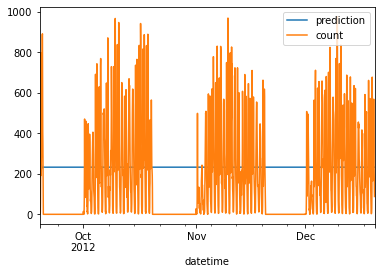

In [106]:
predictions.plot(legend=True);
test['count'].plot(legend=True);

Model didn't learnanything

### Using categorical data as  integer

In [139]:
train = df[:'2012-09-18']
test = df['2012-09-19':'2012-12-19']

**SARIMAX - contain features and target**

In [130]:
from pmdarima import auto_arima

X_train = train.drop(columns='count')
y_train = train['count']
auto_arima(y= y_train,X=X_train,seasonal=False,enforce_invertibility=False).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                15048
Model:               SARIMAX(5, 1, 3)   Log Likelihood              -84221.906
Date:                Sat, 30 Jan 2021   AIC                         168473.812
Time:                        22:54:40   BIC                         168588.096
Sample:                    01-01-2011   HQIC                        168511.724
                         - 09-18-2012                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
season        -0.0973      3.654     -0.027      0.979      -7.258       7.064
workingday   -22.9871      4.783     -4.806      0.000     -32.362     -13.612
weather       -2.2630      1.034     -2.188      0.029      -4.290      -0.236
temp           4.6206      0.357     12.955      0.000       3.922       5.320
humidity      -0.9292      0.080    -11.561      0.000      -1.087      -0.772
windspeed      0.3109      0.099      3.150      0.002       0.117       0.504
ar.L1          0.2648      0.008     33.750      0.000       0.249       0.280
ar.L2         -0.3723      0.007    -53.943      0.000      -0.386      -0.359
ar.L3          0.7754      0.007    110.046      0.000       0.762       0.789
ar.L4         -0.4664      0.006    -75.574      0.000      -0.478      -0.454
ar.L5          0.1679      0.008     20.331      0.000       0.152       0.184
ma.L1          0.0189      0.005      3.725      0.000       0.009       0.029
ma.L2         -0.0104      0.005     -2.079      0.038      -0.020      -0.001
ma.L3         -0.9379      0.005   -189.466      0.000      -0.948      -0.928
sigma2      4338.8349     30.139    143.962      0.000    4279.764    4397.906
===================================================================================
Ljung-Box (Q):                     7346.03   Jarque-Bera (JB):             40520.68
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               2.50   Skew:                             0.50
Prob(H) (two-sided):                  0.00   Kurtosis:                        10.98
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [140]:
model = SARIMAX(train['count'],order=(5,1,3))
results = model.fit()

start=len(train)
end=len(train)+len(test)-1
predictions = results.predict(start=start, end=end, dynamic=False, typ='levels').rename('prediction')

C:\Users\Home\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


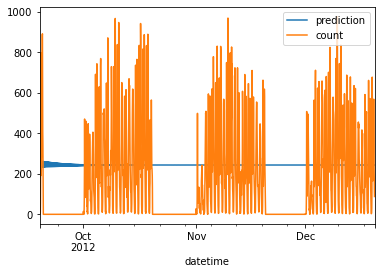

In [141]:
predictions.plot(legend=True);
test['count'].plot(legend=True);

## Evaluate results

In [142]:
from statsmodels.tools.eval_measures import mse,rmse

error1 = mse(test['count'], predictions)
error2 = rmse(test['count'], predictions)
print(f'''
          SARIMAX  with Exogen Numerical features show best results:
          MSE ={error1}, RMSE={error2}'
          Mean ={test["count"].mean()}, Std={test["count"].std()}
          
          Other Model Didn't learn anything.
       ''') 


          SARIMAX  with Exogen Numerical features show best results:
          MSE =49975.32375576655, RMSE=223.55161318086377'
          Mean =151.8201992753623, Std=204.03073946276783
          
          Other Model Didn't learn anything.
       


## Forecast

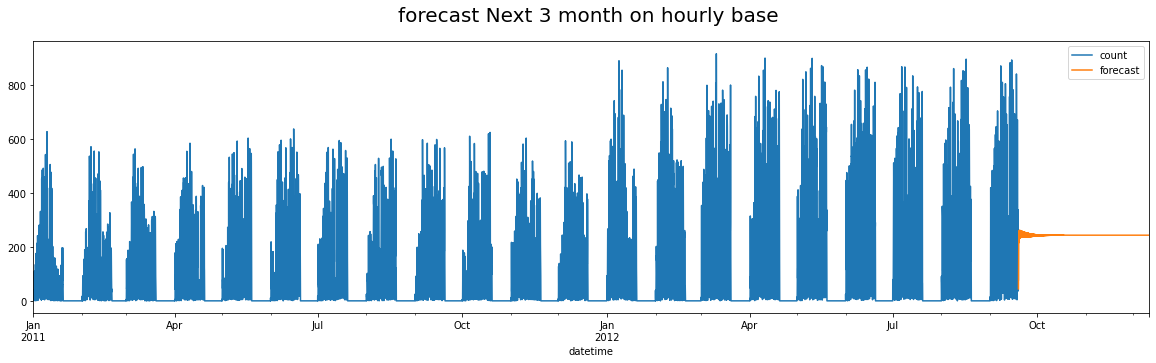

In [143]:
forecast = results.forecast(steps = 2000).rename('forecast');
ax=train['count'].plot(figsize=(20,5),legend=True);
ax.set_title('forecast Next 3 month on hourly base ', size=20,pad =20)
forecast.plot(legend=True);

# Summary

In this case study we tried to predict rentals on hourly base <br>
Our data contain Exogen features that most of them impact and correlate with rentals. <br>
We can see that algoritm contain Exogen features show the best results. <br>
However, the fact our data suffer from sparsity zeros (~40%) impact on prediction and forecast. <br>
My recommendation is to increase time frame to 4 hours interval . <br>
4 hours interval as we show in EDA section have less noise and can be measure more efficiently. <br>

In [ ]:
## *